In [1]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
from statsmodels.formula.api import ols
pd.set_option("display.max_columns", 500)
%matplotlib inline

In [2]:
cleaned_county_data = pd.read_csv("data/cleaned_county_health_data_1-2.csv")

In [152]:
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import Lasso
from sklearn.linear_model import Ridge
from sklearn.linear_model import LassoLarsIC

from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import KFold
from sklearn.model_selection import cross_validate
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler

import scipy.stats as stats

import statsmodels.api as sm
from statsmodels.stats.outliers_influence import variance_inflation_factor

In [4]:
health_behaviors = ['adult_smoking', 'adult_obesity', 'food_environment_index',
                    'physical_inactivity', 'access_to_exercise_opportunities',
                    'excessive_drinking', 'alcohol_impaired_driving_deaths',
                    'sexually_transmitted_infections', 'teen_births']

clinical_care = ['uninsured', 'primary_care_physicians', 'dentists',
                 'mental_health_providers', 'preventable_hospital_stays',
                 'mammography_screening', 'flu_vaccinations']

socio_econ_environ = ['high_school_graduation', 'some_college', 'unemployment',
                      'children_in_poverty', 'income_inequality',
                      'children_in_single_parent_households', 'social_associations',
                      'violent_crime', 'injury_deaths']

phys_environ = ['air_pollution_particulate_matter', 'drinking_water_violations',
                'severe_housing_problems', 'driving_alone_to_work',
                'long_commute_driving_alone']

factor_groups = [health_behaviors, clinical_care,
                 socio_econ_environ, phys_environ]

In [5]:
target_var = ["premature_death"]
admin_vars = ["statecode", "countycode", "fipscode", "state", "county", "year", "county_ranked"]

In [6]:
target = cleaned_county_data[target_var]
features = cleaned_county_data.drop(columns = admin_vars+target_var)

X_train, X_test, y_train, y_test = train_test_split(features, target, random_state = 12, test_size = .2)

In [7]:
train = pd.merge(y_train, X_train, left_index=True, right_index=True)

In [8]:
pipe = Pipeline([
   ('sc', StandardScaler()),
   ('lr', LinearRegression())])
baseline = cross_val_score(pipe, X_train, y_train, cv=5)

In [9]:
print(np.mean(baseline))
print(np.std(baseline))

0.843089809726117
0.005077566652554421


In [17]:
X_train_std = StandardScaler().fit_transform(X_train)
y_train_std = StandardScaler().fit_transform(y_train) 
train_std = StandardScaler().fit_transform(train)

In [167]:
X_test_std = StandardScaler().fit_transform(X_test)
y_test_std = StandardScaler().fit_transform(y_test) 

In [58]:
X_train_std_df = pd.DataFrame(X_train_std, columns=X_train.columns)
y_train_std_df = pd.DataFrame(y_train_std, columns=y_train.columns) 
train_std_df = pd.DataFrame(train_std, columns=train.columns)

In [168]:
X_test_std_df = pd.DataFrame(X_test_std, columns=X_train.columns)
y_test_std_df = pd.DataFrame(y_test_std, columns=y_train.columns) 

In [57]:
train_std_df

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30
0,-0.308235,0.034109,-1.731776,-0.415537,-1.349742,1.007648,0.519306,0.279841,0.707454,-1.022550,0.084461,1.095059,1.161133,1.590643,-0.200526,1.350790,1.479067,-0.280466,1.489139,-0.290220,0.007918,0.904466,0.608164,-0.508101,0.935094,-0.380351,-0.483246,1.188358,1.276761,-0.048688,-1.146136
1,0.653660,1.011254,-0.222631,-0.415537,-0.177323,0.543499,0.238786,-1.032528,-0.112747,-0.285485,0.632644,1.413617,0.619071,1.026400,-0.083397,0.216060,-0.246744,0.543119,0.551362,-0.549715,0.054430,1.535788,-0.052686,0.128454,0.384751,0.158566,0.219394,-0.841497,-0.150855,-0.006696,-1.030132
2,-0.566472,-0.355748,-0.681936,0.398660,-0.984562,1.206634,1.434448,0.812743,0.452533,0.269845,-0.806614,-0.033391,0.822745,0.131728,0.068217,1.067107,0.788743,0.666792,0.546195,0.255360,-0.143244,-0.147348,0.981334,0.189556,0.417309,-0.728729,0.922033,1.188358,-0.063071,0.439349,-1.270426
3,0.989543,-0.670978,-0.485091,-0.822635,0.649136,-1.996217,0.390463,-0.443113,-0.295418,0.560201,1.650463,-1.011701,-1.397301,-0.781450,0.181779,-0.493145,-0.016636,1.134619,-0.254197,0.403155,0.321870,0.043907,-0.420648,-0.820294,0.170881,-0.382524,0.435591,-0.841497,-0.478482,0.508340,0.958507
4,-0.704598,1.378887,0.586620,-0.415537,1.052755,-0.617170,-0.282934,-0.817165,0.228966,0.059021,0.428733,0.008353,-0.646974,-0.108364,0.091405,1.350790,0.673689,0.217595,-0.464064,-0.648223,0.159080,-0.882191,0.192485,0.019059,-0.341974,0.175391,0.165345,1.188358,-0.090009,-0.189477,-1.253854
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1973,2.016054,1.944498,-0.003914,-0.110213,1.244955,0.219321,-1.157047,0.255344,-0.691204,1.693459,0.135915,-0.340732,-0.609310,-0.781145,1.934556,0.216060,-0.131690,1.119111,-1.554077,0.292525,1.031169,0.997789,0.652050,-1.239558,-0.183043,1.030782,0.003197,1.188358,-0.073254,0.558644,-0.135244
1974,5.379445,2.287765,1.024054,-2.451028,-0.715483,-0.355671,-0.152492,2.067163,4.814365,3.755487,1.691194,0.591125,-0.086855,-0.673864,0.901797,-0.918669,-0.361798,-2.486582,-0.685721,5.815944,1.077680,0.056184,1.088629,-0.962260,1.378743,3.528997,-1.780427,-0.841497,2.373988,-1.782213,-0.234676
1975,0.738611,-0.670031,-1.600546,-2.247479,-1.234422,0.566668,-1.148536,-0.494120,0.490703,0.981777,-0.239470,-0.491635,-0.568443,5.083547,-0.654774,-0.493145,0.098418,-1.004348,-0.016700,0.927944,0.914890,1.568849,2.414410,0.595768,0.041063,2.074883,-2.537115,1.188358,0.610166,-0.870906,-1.228996
1976,2.385819,1.229628,1.111540,-1.127958,1.187295,-0.730091,-1.407224,-0.689166,0.648381,1.640002,2.147210,-1.249324,-1.196446,-0.726344,0.370850,-1.486034,0.213472,-0.407464,-1.019653,-0.098672,0.880007,0.118206,0.698530,0.342324,-0.034762,2.081215,-0.213000,1.188358,-0.860435,0.329752,-0.052384


In [10]:
X_train_std = sm.add_constant(X_train_std)
base_model_sm = sm.OLS(y_train_std, X_train_std, hasconst=True)
regress_base_sm = base_model_sm.fit()
regress_base_sm.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                      y   R-squared:                       0.850
Model:                            OLS   Adj. R-squared:                  0.848
Method:                 Least Squares   F-statistic:                     368.2
Date:                Tue, 22 Oct 2019   Prob (F-statistic):               0.00
Time:                        13:08:18   Log-Likelihood:                -929.50
No. Observations:                1978   AIC:                             1921.
Df Residuals:                    1947   BIC:                             2094.
Df Model:                          30                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const       8.346e-16      0.009   9.51e-14      1.000      -0.017       0.017
x1             0.1236      0.015      8.141      0.000       0.094       0.153
x2             0.0301      0.014      2.083      0.037       0.002       0.058
x3            -0.0608      0.015     -4.109      0.000      -0.090      -0.032
x4             0.0744      0.017      4.449      0.000       0.042       0.107
x5            -0.0116      0.012     -0.962      0.336      -0.035       0.012
x6            -0.0716      0.013     -5.509      0.000      -0.097      -0.046
x7             0.0183      0.009      1.993      0.046       0.000       0.036
x8             0.0708      0.014      4.954      0.000       0.043       0.099
x9             0.1493      0.018      8.455      0.000       0.115       0.184
x10            0.0263      0.013      2.003      0.045       0.001       0.052
x11           -0.0082      0.013     -0.648      0.517      -0.033       0.017
x12            0.0015      0.013      0.111      0.912      -0.025       0.028
x13            0.0280      0.011      2.488      0.013       0.006       0.050
x14            0.0259      0.011      2.339      0.019       0.004       0.048
x15           -0.0099      0.012     -0.796      0.426      -0.034       0.014
x16            0.0200      0.012      1.721      0.085      -0.003       0.043
x17            0.0373      0.011      3.526      0.000       0.017       0.058
x18            0.0408      0.016      2.507      0.012       0.009       0.073
x19            0.0455      0.012      3.652      0.000       0.021       0.070
x20            0.0975      0.023      4.235      0.000       0.052       0.143
x21            0.0488      0.013      3.783      0.000       0.023       0.074
x22            0.0693      0.015      4.600      0.000       0.040       0.099
x23           -0.0220      0.011     -1.926      0.054      -0.044       0.000
x24            0.0224      0.012      1.925      0.054      -0.000       0.045
x25            0.4426      0.011     38.800      0.000       0.420       0.465
x26            0.0493      0.012      4.289      0.000       0.027       0.072
x27           -0.0140      0.009     -1.526      0.127      -0.032       0.004
x28           -0.0363      0.014     -2.623      0.009      -0.063      -0.009
x29            0.0495      0.012      4.257      0.000       0.027       0.072
x30            0.0666      0.012      5.665      0.000       0.044       0.090
==============================================================================
Omnibus:                      170.155   Durbin-Watson:                   1.995
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              463.979
Skew:                           0.467   Prob(JB):                    1.77e-101
Kurtosis:                       5.181   Cond. No.                         8.32
==

In [11]:
ridge_base = base_model_sm.fit_regularized(L1_wt=0)
ridge_base_data = list(zip(['const']+list(X_train.columns), ridge_base.params))
ridge_base_data_df = pd.DataFrame(ridge_base_data, columns=['Feature','Coef'])
ridge_base_data_df

,Feature,Coef
0,const,8.258995e-16
1,adult_smoking,1.236393e-01
2,adult_obesity,3.012411e-02
3,food_environment_index,-6.076151e-02
4,physical_inactivity,7.440241e-02
5,access_to_exercise_opportunities,-1.162050e-02
6,excessive_drinking,-7.164147e-02
7,alcohol_impaired_driving_deaths,1.832330e-02
8,sexually_transmitted_infections,7.078890e-02
9,teen_births,1.492777e-01


In [14]:
lasso_base = base_model_sm.fit_regularized(L1_wt=1)
lasso_base_data = list(zip(['const']+list(X_train.columns), lasso_base.params))
lasso_base_data_df = pd.DataFrame(lasso_base_data, columns=['Feature','Coef'])
lasso_base_data_df
# lasso_base_data_df.sort_values(by='Coef')

,Feature,Coef
0,const,0.000000
1,adult_smoking,0.123634
2,adult_obesity,0.030115
3,food_environment_index,-0.060760
4,physical_inactivity,0.074401
5,access_to_exercise_opportunities,-0.011621
6,excessive_drinking,-0.071646
7,alcohol_impaired_driving_deaths,0.018325
8,sexually_transmitted_infections,0.070792
9,teen_births,0.149291


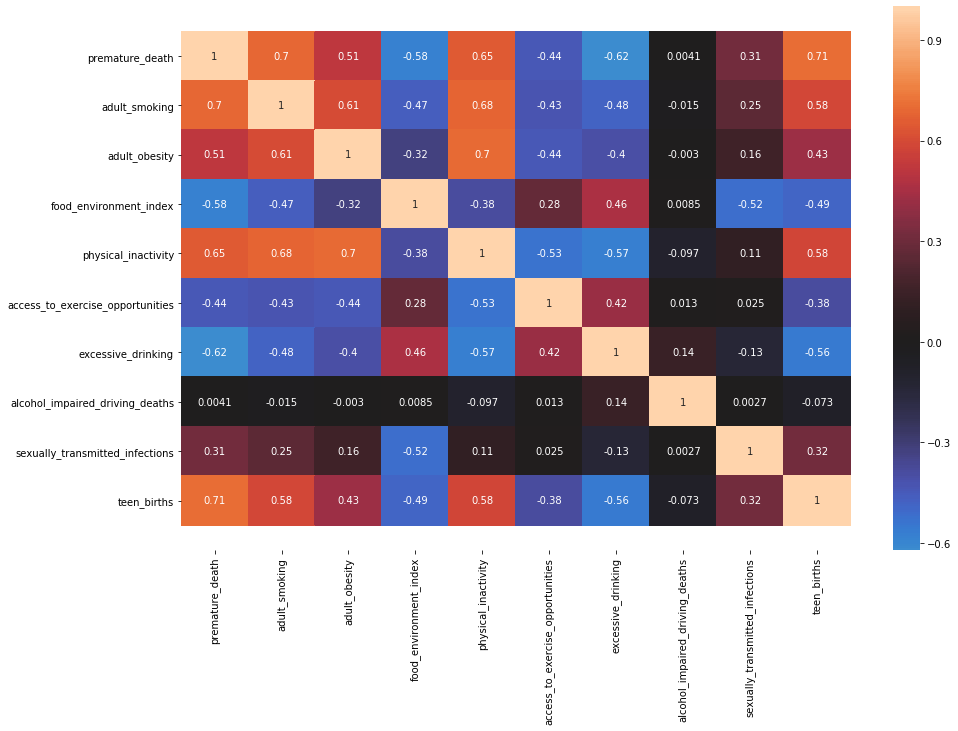

In [18]:
fig, ax = plt.subplots(figsize = (15, 10))
sns.heatmap(train[target_var+health_behaviors].corr(),
           center = 0, annot = True)
ax.set_ylim(len(target_var+health_behaviors)+0.5, -0.5);

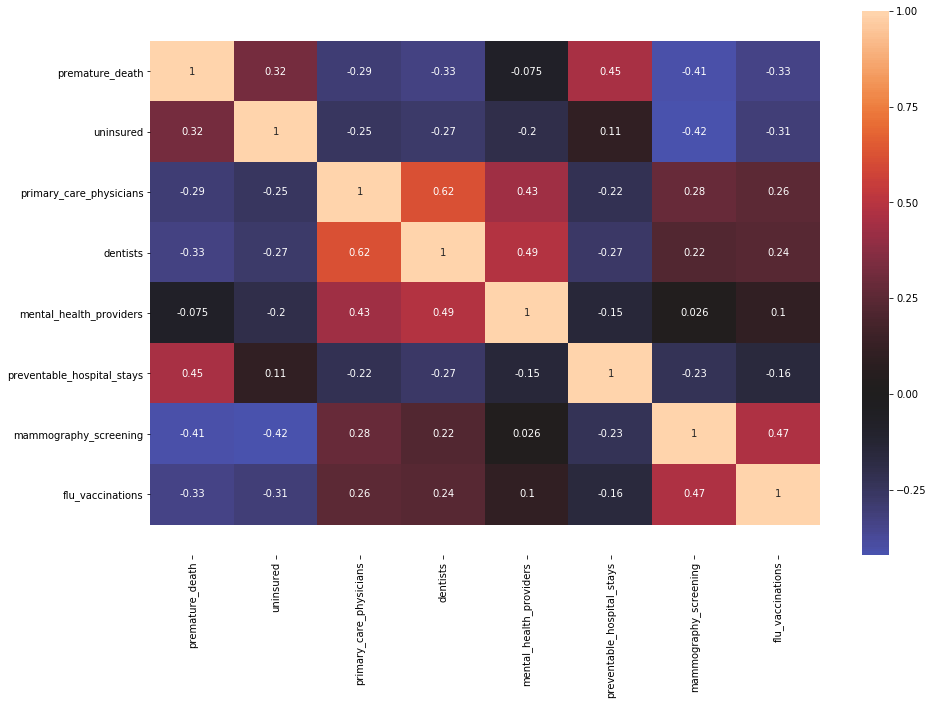

In [19]:
fig, ax = plt.subplots(figsize = (15, 10))
sns.heatmap(train[target_var+clinical_care].corr(),
           center = 0, annot = True)
ax.set_ylim(len(target_var+clinical_care)+0.5, -0.5);

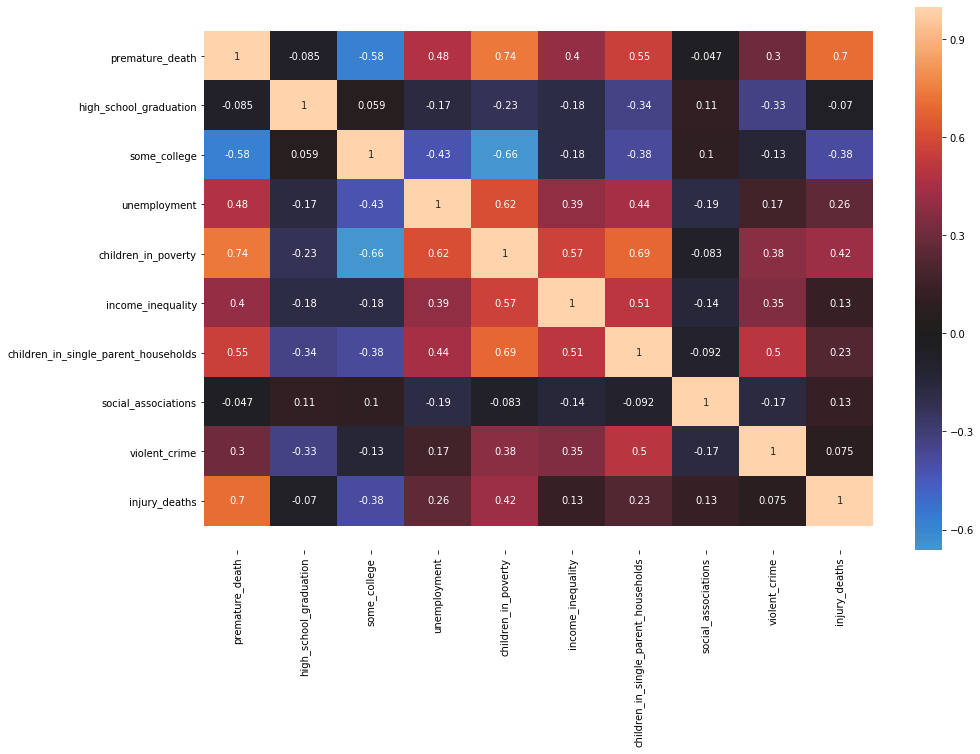

In [20]:
fig, ax = plt.subplots(figsize = (15, 10))
sns.heatmap(train[target_var+socio_econ_environ].corr(),
           center = 0, annot = True)
ax.set_ylim(len(target_var+socio_econ_environ)+0.5, -0.5);

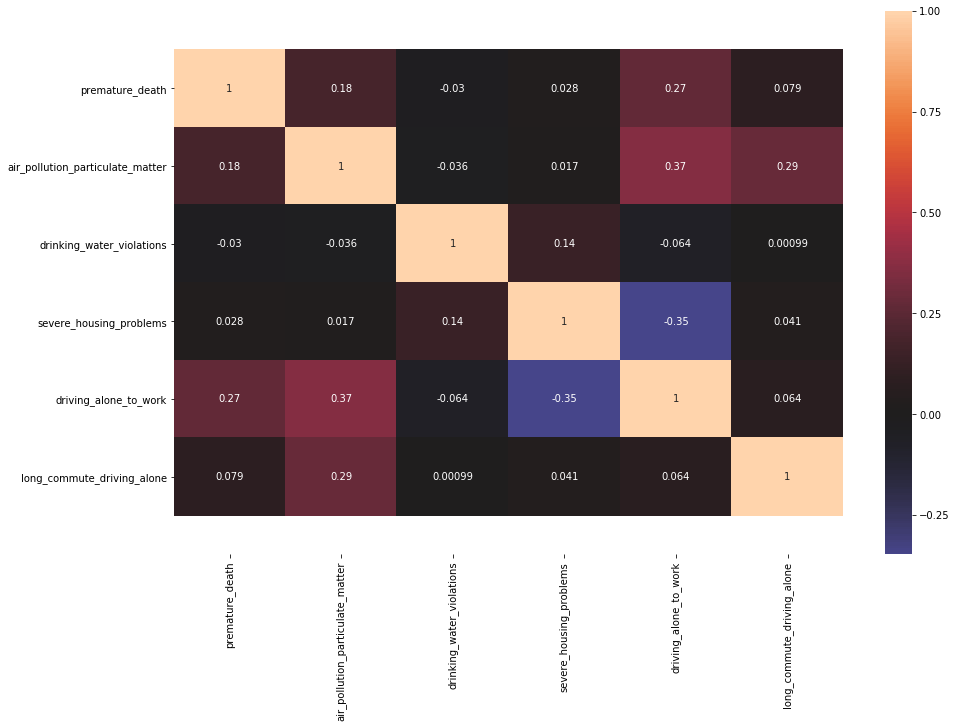

In [21]:
fig, ax = plt.subplots(figsize = (15, 10))
sns.heatmap(train[target_var+phys_environ].corr(),
           center = 0, annot = True)
ax.set_ylim(len(target_var+phys_environ)+0.5, -0.5);

In [22]:
all_corr_df = train.corr()
all_corr_df.premature_death.abs().sort_values(ascending=False)

premature_death                         1.000000
children_in_poverty                     0.738289
teen_births                             0.707047
injury_deaths                           0.702457
adult_smoking                           0.695879
physical_inactivity                     0.647399
excessive_drinking                      0.620281
some_college                            0.582470
food_environment_index                  0.579951
children_in_single_parent_households    0.553102
adult_obesity                           0.512692
unemployment                            0.477808
preventable_hospital_stays              0.452075
access_to_exercise_opportunities        0.440789
mammography_screening                   0.407670
income_inequality                       0.399789
flu_vaccinations                        0.332465
dentists                                0.328641
uninsured                               0.321818
sexually_transmitted_infections         0.314778
violent_crime       

In [23]:
def variance_inflation_factor_printout(feature_list, df):
    feature_df = df[feature_list]
    vif = [variance_inflation_factor(feature_df.values, i) for i in range(feature_df.shape[1])]
    data = list(zip(feature_list, vif))
    data_df = pd.DataFrame(data, columns=['Feature','VIF'])
    return data_df

In [24]:
variance_inflation_factor_printout(['primary_care_physicians', 'dentists', 'mental_health_providers'], train)

,Feature,VIF
0,primary_care_physicians,6.263248
1,dentists,6.779399
2,mental_health_providers,2.793322


We eliminated the 'dentist' covariates becaues it showed lower statistically sigificance in our base OLS regression and was also moderately correlated with 'mental_health_providers' and 'primary_care_physicans'  covariates which we are including in our model at this point. 

We are also eliminating 'social associations' and 'drinking_water_violations' because they had lower statistically sigificants and low correlation with our target feature (premature death).

In [92]:
lars_model_bic = LassoLarsIC(criterion='bic')
lars_model_bic.fit(X_train_std_df, y_train_std_df['premature_death'])

lars_model_bic_rss = lars_model_bic.score(X_train_std_df, y_train_std_df['premature_death'])
lars_model_bic_results = [lars_model_bic_rss] + [lars_model_bic.intercept_] + list(lars_model_bic.coef_)

lars_model_bic_dict = {'bic': lars_model_bic_results}
lars_model_bic_df = pd.DataFrame.from_dict(lars_model_bic_dict,
                                           orient="index",
                                           columns=lasso_cols)

In [93]:
lars_model_bic_df

,rss,intercept,adult_smoking,adult_obesity,food_environment_index,physical_inactivity,access_to_exercise_opportunities,excessive_drinking,alcohol_impaired_driving_deaths,sexually_transmitted_infections,teen_births,uninsured,primary_care_physicians,dentists,mental_health_providers,preventable_hospital_stays,mammography_screening,flu_vaccinations,high_school_graduation,some_college,unemployment,children_in_poverty,income_inequality,children_in_single_parent_households,social_associations,violent_crime,injury_deaths,air_pollution_particulate_matter,drinking_water_violations,severe_housing_problems,driving_alone_to_work,long_commute_driving_alone
bic,0.842123,1.983143e-16,0.141375,0.013137,-0.056642,0.083475,0.0,-0.070516,0.0,0.05757,0.138262,0.0,0.0,0.0,0.0,0.024154,0.0,0.0,0.0,0.0,0.022245,0.091566,0.033506,0.061993,0.0,0.0,0.414909,0.03975,0.0,0.0,0.042062,0.036989


In [94]:
lars_model_bic_df.iloc[0][lars_model_bic_df.iloc[0] == 0]

access_to_exercise_opportunities    0.0
alcohol_impaired_driving_deaths     0.0
uninsured                           0.0
primary_care_physicians             0.0
dentists                            0.0
mental_health_providers             0.0
mammography_screening               0.0
flu_vaccinations                    0.0
high_school_graduation              0.0
some_college                        0.0
social_associations                 0.0
violent_crime                       0.0
drinking_water_violations           0.0
severe_housing_problems             0.0
Name: bic, dtype: float64

In [126]:
bic_keep_feats = list(lars_model_bic_df.iloc[0][lars_model_bic_df.iloc[0] != 0].index[2:])
lars_model_bic_df.iloc[0][lars_model_bic_df.iloc[0] != 0]

rss                                     8.421229e-01
intercept                               1.983143e-16
adult_smoking                           1.413753e-01
adult_obesity                           1.313729e-02
food_environment_index                 -5.664222e-02
physical_inactivity                     8.347467e-02
excessive_drinking                     -7.051567e-02
sexually_transmitted_infections         5.757046e-02
teen_births                             1.382624e-01
preventable_hospital_stays              2.415353e-02
unemployment                            2.224499e-02
children_in_poverty                     9.156557e-02
income_inequality                       3.350648e-02
children_in_single_parent_households    6.199350e-02
injury_deaths                           4.149087e-01
air_pollution_particulate_matter        3.974965e-02
driving_alone_to_work                   4.206169e-02
long_commute_driving_alone              3.698865e-02
Name: bic, dtype: float64

In [107]:
lars_model_aic = LassoLarsIC(criterion='aic')
lars_model_aic.fit(X_train_std_df, y_train_std_df['premature_death'])

lars_model_aic_rss = lars_model_aic.score(X_train_std_df, y_train_std_df['premature_death'])
lars_model_aic_results = [lars_model_aic_rss] + [lars_model_aic.intercept_] + list(lars_model_aic.coef_)

lars_model_aic_dict = {'aic': lars_model_aic_results}
lars_model_aic_df = pd.DataFrame.from_dict(lars_model_aic_dict,
                                           orient="index",
                                           columns=lasso_cols)

In [98]:
lars_model_aic_df

,rss,intercept,adult_smoking,adult_obesity,food_environment_index,physical_inactivity,access_to_exercise_opportunities,excessive_drinking,alcohol_impaired_driving_deaths,sexually_transmitted_infections,teen_births,uninsured,primary_care_physicians,dentists,mental_health_providers,preventable_hospital_stays,mammography_screening,flu_vaccinations,high_school_graduation,some_college,unemployment,children_in_poverty,income_inequality,children_in_single_parent_households,social_associations,violent_crime,injury_deaths,air_pollution_particulate_matter,drinking_water_violations,severe_housing_problems,driving_alone_to_work,long_commute_driving_alone
bic,0.844241,2.156315e-16,0.138944,0.016558,-0.059144,0.08163,0.0,-0.071396,0.0,0.061966,0.140701,0.0,0.0,0.0,0.0,0.025579,0.0,0.0,0.0,0.0,0.025919,0.08477,0.038709,0.060578,0.0,0.004308,0.42268,0.042601,0.0,0.0,0.047648,0.045012


In [110]:
lars_model_aic_df.iloc[0][lars_model_aic_df.iloc[0] == 0]

access_to_exercise_opportunities    0.0
alcohol_impaired_driving_deaths     0.0
uninsured                           0.0
primary_care_physicians             0.0
dentists                            0.0
mental_health_providers             0.0
mammography_screening               0.0
flu_vaccinations                    0.0
high_school_graduation              0.0
some_college                        0.0
social_associations                 0.0
violent_crime                       0.0
drinking_water_violations           0.0
severe_housing_problems             0.0
Name: bic, dtype: float64

In [112]:
aic_keep_feats = list(lars_model_aic_df.iloc[0][lars_model_aic_df.iloc[0] != 0].index[2:])
lars_model_aic_df.iloc[0][lars_model_aic_df.iloc[0] != 0]

rss                                     8.442411e-01
intercept                               2.156315e-16
adult_smoking                           1.389440e-01
adult_obesity                           1.655846e-02
food_environment_index                 -5.914359e-02
physical_inactivity                     8.163027e-02
excessive_drinking                     -7.139632e-02
sexually_transmitted_infections         6.196648e-02
teen_births                             1.407006e-01
preventable_hospital_stays              2.557862e-02
unemployment                            2.591905e-02
children_in_poverty                     8.476966e-02
income_inequality                       3.870894e-02
children_in_single_parent_households    6.057828e-02
violent_crime                           4.308235e-03
injury_deaths                           4.226804e-01
air_pollution_particulate_matter        4.260132e-02
driving_alone_to_work                   4.764841e-02
long_commute_driving_alone              4.5011

In [141]:
# Not too much collinearity, but children_in_poverty is a little worrisome.
variance_inflation_factor_printout(bic_keep_feats, train_std_df)

,Feature,VIF
0,adult_smoking,2.640083
1,adult_obesity,2.347140
2,food_environment_index,2.539830
3,physical_inactivity,3.314849
4,excessive_drinking,2.013996
5,sexually_transmitted_infections,2.086921
6,teen_births,2.778462
7,preventable_hospital_stays,1.541753
8,unemployment,1.729444
9,children_in_poverty,5.724357


In [135]:
X_train_bic_cols = '+'.join(bic_keep_feats)
formula_bic = target_var[0] + '~' + X_train_bic_cols
model_sm_bic = ols(formula=formula_bic, data=train_std_df[target_var+bic_keep_feats])
regress_bic = model_sm_bic.fit()
regress_bic.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:        premature_death   R-squared:                       0.847
Model:                            OLS   Adj. R-squared:                  0.845
Method:                 Least Squares   F-statistic:                     676.1
Date:                Tue, 22 Oct 2019   Prob (F-statistic):               0.00
Time:                        14:17:21   Log-Likelihood:                -952.97
No. Observations:                1978   AIC:                             1940.
Df Residuals:                    1961   BIC:                             2035.
Df Model:                          16                                         
Covariance Type:            nonrobust                                         
========================================================================================================
                                           coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------------------------------
Intercept                             1.845e-16      0.009   2.09e-14      1.000      -0.017       0.017
adult_smoking                            0.1308      0.014      9.101      0.000       0.103       0.159
adult_obesity                            0.0250      0.014      1.844      0.065      -0.002       0.052
food_environment_index                  -0.0672      0.014     -4.770      0.000      -0.095      -0.040
physical_inactivity                      0.0765      0.016      4.747      0.000       0.045       0.108
excessive_drinking                      -0.0729      0.013     -5.805      0.000      -0.098      -0.048
sexually_transmitted_infections          0.0797      0.013      6.239      0.000       0.055       0.105
teen_births                              0.1497      0.015     10.155      0.000       0.121       0.179
preventable_hospital_stays               0.0291      0.011      2.648      0.008       0.008       0.051
unemployment                             0.0346      0.012      2.976      0.003       0.012       0.057
children_in_poverty                      0.0674      0.021      3.185      0.001       0.026       0.109
income_inequality                        0.0532      0.012      4.333      0.000       0.029       0.077
children_in_single_parent_households     0.0603      0.014      4.211      0.000       0.032       0.088
injury_deaths                            0.4444      0.011     40.715      0.000       0.423       0.466
air_pollution_particulate_matter         0.0524      0.011      4.745      0.000       0.031       0.074
driving_alone_to_work                    0.0620      0.011      5.747      0.000       0.041       0.083
long_commute_driving_alone               0.0673      0.010      6.703      0.000       0.048       0.087
==============================================================================
Omnibus:                      166.567   Durbin-Watson:                   1.996
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              451.896
Skew:                           0.458   Prob(JB):                     7.45e-99
Kurtosis:                       5.155   Cond. No.                         6.81
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [115]:
X_train_aic_cols = '+'.join(aic_keep_feats)
formula_aic = target_var[0] + '~' + X_train_aic_cols
model_sm_aic = ols(formula=formula_aic, data=train_std_df[target_var+aic_keep_feats])
regress_aic = model_sm_aic.fit()
regress_aic.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:        premature_death   R-squared:                       0.847
Model:                            OLS   Adj. R-squared:                  0.845
Method:                 Least Squares   F-statistic:                     636.8
Date:                Tue, 22 Oct 2019   Prob (F-statistic):               0.00
Time:                        14:06:13   Log-Likelihood:                -951.96
No. Observations:                1978   AIC:                             1940.
Df Residuals:                    1960   BIC:                             2041.
Df Model:                          17                                         
Covariance Type:            nonrobust                                         
========================================================================================================
                                           coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------------------------------
Intercept                             1.845e-16      0.009   2.09e-14      1.000      -0.017       0.017
adult_smoking                            0.1323      0.014      9.182      0.000       0.104       0.161
adult_obesity                            0.0259      0.014      1.912      0.056      -0.001       0.053
food_environment_index                  -0.0660      0.014     -4.673      0.000      -0.094      -0.038
physical_inactivity                      0.0766      0.016      4.756      0.000       0.045       0.108
excessive_drinking                      -0.0738      0.013     -5.873      0.000      -0.098      -0.049
sexually_transmitted_infections          0.0740      0.013      5.522      0.000       0.048       0.100
teen_births                              0.1474      0.015      9.934      0.000       0.118       0.176
preventable_hospital_stays               0.0295      0.011      2.684      0.007       0.008       0.051
unemployment                             0.0360      0.012      3.083      0.002       0.013       0.059
children_in_poverty                      0.0661      0.021      3.123      0.002       0.025       0.108
income_inequality                        0.0530      0.012      4.312      0.000       0.029       0.077
children_in_single_parent_households     0.0567      0.015      3.900      0.000       0.028       0.085
violent_crime                            0.0161      0.011      1.412      0.158      -0.006       0.038
injury_deaths                            0.4440      0.011     40.668      0.000       0.423       0.465
air_pollution_particulate_matter         0.0504      0.011      4.532      0.000       0.029       0.072
driving_alone_to_work                    0.0630      0.011      5.823      0.000       0.042       0.084
long_commute_driving_alone               0.0670      0.010      6.675      0.000       0.047       0.087
==============================================================================
Omnibus:                      170.136   Durbin-Watson:                   1.998
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              462.853
Skew:                           0.468   Prob(JB):                    3.11e-101
Kurtosis:                       5.177   Cond. No.                         6.90
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [139]:
# dropping 'adult_obesity' because it was the only feature with a p_value above 0.05
# testing how this impacts the model
adj_bic_feats = [bic_keep_feats[0]]+bic_keep_feats[2:]

In [140]:
X_train_adj_bic_cols = '+'.join(adj_bic_feats)
formula_adj_bic = target_var[0] + '~' + X_train_adj_bic_cols
model_sm_adj_bic = ols(formula=formula_adj_bic, data=train_std_df[target_var+adj_bic_feats])
regress_adj_bic = model_sm_adj_bic.fit()
regress_adj_bic.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:        premature_death   R-squared:                       0.846
Model:                            OLS   Adj. R-squared:                  0.845
Method:                 Least Squares   F-statistic:                     720.1
Date:                Tue, 22 Oct 2019   Prob (F-statistic):               0.00
Time:                        14:19:47   Log-Likelihood:                -954.68
No. Observations:                1978   AIC:                             1941.
Df Residuals:                    1962   BIC:                             2031.
Df Model:                          15                                         
Covariance Type:            nonrobust                                         
========================================================================================================
                                           coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------------------------------
Intercept                             1.845e-16      0.009   2.08e-14      1.000      -0.017       0.017
adult_smoking                            0.1367      0.014      9.742      0.000       0.109       0.164
food_environment_index                  -0.0679      0.014     -4.816      0.000      -0.096      -0.040
physical_inactivity                      0.0891      0.015      6.118      0.000       0.061       0.118
excessive_drinking                      -0.0730      0.013     -5.813      0.000      -0.098      -0.048
sexually_transmitted_infections          0.0819      0.013      6.428      0.000       0.057       0.107
teen_births                              0.1476      0.015     10.034      0.000       0.119       0.176
preventable_hospital_stays               0.0302      0.011      2.749      0.006       0.009       0.052
unemployment                             0.0355      0.012      3.053      0.002       0.013       0.058
children_in_poverty                      0.0672      0.021      3.172      0.002       0.026       0.109
income_inequality                        0.0497      0.012      4.095      0.000       0.026       0.074
children_in_single_parent_households     0.0612      0.014      4.275      0.000       0.033       0.089
injury_deaths                            0.4441      0.011     40.665      0.000       0.423       0.465
air_pollution_particulate_matter         0.0525      0.011      4.753      0.000       0.031       0.074
driving_alone_to_work                    0.0663      0.011      6.278      0.000       0.046       0.087
long_commute_driving_alone               0.0657      0.010      6.565      0.000       0.046       0.085
==============================================================================
Omnibus:                      166.777   Durbin-Watson:                   1.992
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              451.869
Skew:                           0.459   Prob(JB):                     7.55e-99
Kurtosis:                       5.154   Cond. No.                         6.60
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [142]:
variance_inflation_factor_printout(adj_bic_feats, train_std_df)

,Feature,VIF
0,adult_smoking,2.511788
1,food_environment_index,2.538166
2,physical_inactivity,2.709817
3,excessive_drinking,2.013923
4,sexually_transmitted_infections,2.070006
5,teen_births,2.761052
6,preventable_hospital_stays,1.537365
7,unemployment,1.726457
8,children_in_poverty,5.724133
9,income_inequality,1.882313


In [145]:
pipe = Pipeline([
   ('sc', StandardScaler()),
   ('lr', LinearRegression())])
adj_bic_cvs = cross_val_score(pipe, X_train[adj_bic_feats], y_train, cv=10)
print(np.mean(adj_bic_cvs))
print(np.std(adj_bic_cvs))

0.8424046776154575
0.020633882545935997


In [146]:
pipe = Pipeline([
   ('sc', StandardScaler()),
   ('lr', LinearRegression())])
bic_cvs = cross_val_score(pipe, X_train[bic_keep_feats], y_train, cv=10)
print(np.mean(bic_cvs))
print(np.std(bic_cvs))

0.8426192893101406
0.020765667629039666


Choosing the results of the bic based LassoLARS because it produced the same results as the aic based model, but with one fewer feature. Similarly adult obesity was removed because it was the only remaining feature with a p-value above 0.05, and upon its removal the BIC dropped slightly and the R-squared values were negligibly affected.

In [161]:
final_features = adj_bic_feats

In [157]:
# lr_model_final = LinearRegression()
# lr_model_final.fit(X_train_std_df[final_features], y_train_std_df['premature_death'])
# residuals = y_train_std_df['premature_death'] - lr_model_final.predict(X_train_std_df[final_features])

In [148]:
import statsmodels.api as sm

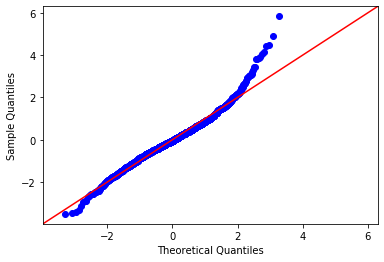

In [165]:
sm.graphics.qqplot(regress_adj_bic.resid, dist=stats.norm, line='45', fit=True);

In [162]:
regress_adj_bic.predict(X_train_std_df[final_features]).describe()

count    1.978000e+03
mean     1.059707e-16
std      9.201639e-01
min     -2.457847e+00
25%     -6.239122e-01
50%     -5.477218e-02
75%      5.816397e-01
max      4.998903e+00
dtype: float64

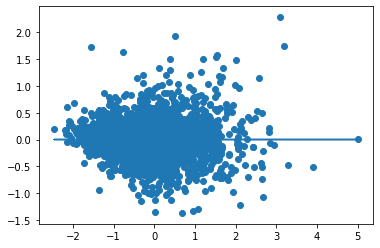

In [164]:
plt.scatter(regress_adj_bic.predict(X_train_std_df[final_features]), regress_adj_bic.resid)
plt.plot(regress_adj_bic.predict(X_train_std_df[final_features]), [0 for i in range(len(train))])

In [169]:
test_predictions = regress_adj_bic.predict(X_test_std_df[final_features])

In [184]:
from sklearn.metrics import r2_score
from sklearn.metrics import mean_squared_error

In [182]:
r2_score(y_test_std_df['premature_death'],test_predictions)

0.8406518192173286

In [185]:
mean_squared_error(y_test_std_df['premature_death'], test_predictions)

0.1593481807826714

In [178]:
regress_adj_bic.rsquared

0.84627354936709

In [188]:
regress_adj_bic.mse_resid

0.1549800812191111